# Schrodinger equation
---

$$
\begin{aligned}
\varepsilon u_t - i\frac{\epsilon^2}{2}\Delta u + i V(x)u = 0, \ t \in \mathbb{R}, x\in \mathbb{R}^d, \\
u(x, t = 0) = u_0(x),
\end{aligned}
$$
where $V$ is a given electrostatic potential, $0 < \varepsilon \ll 1$.

---

Example 1 in Shi Jin's paper (2008-jy-phase.pdf):
$$
u(x, 0) = \sqrt{n_0(x)}e^{iS_0(x)/\varepsilon},
$$
(3.9-3.10)
$$
n_0(x) = e^{-25x^2}, \ S_0(x) = -0.2\log(2\cosh(5x)).
$$

Periodic BC.

Domain: $[-0.25, 0.25]\times [0, 0.5]$.

---

Consider the real and imag part of $u$, i.e., 
$$
u(x, t) = p(x, t) + iq(x, t),
$$
then
$$
\begin{aligned}
&\varepsilon p_t+\frac{\varepsilon^2}{2}q_{xx} - V(x)q = 0, \\
&\varepsilon q_t-\frac{\varepsilon^2}{2}p_{xx} + V(x)p = 0,
\end{aligned}
$$
with ic
$$
p(x, 0) = e^{-25x^2}\cos(-0.2\log(2\cosh(5x))/\varepsilon), \ q(x, 0) = e^{-25x^2}\sin(-0.2\log(2\cosh(5x))/\varepsilon),
$$
and bc
$$
p(x_0, t) = p(x_1, t), q(x_0, t) = q(x_1, t), p_x(x_0, t) = p_x(x_1, t), q_x(x_0, t) = q_x(x_1, t).
$$

In [1]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple

In [2]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [2] + [32]*8 + [2] # (x, t) -> (u, v)
c0 = 2.0
w0 = jnp.array([[10.0], [10.0]]) # (w_x, w_t)
w1 = jnp.array([[2.0, 2.0]]) # (w_u, w_v)
lambda_0 = 1e-8
direct_params = init_siren_params(subkey, layers, c0, w0, w1)
# direct_params = init_tanh_params(subkey, layers)

domain = jnp.array([[-0.25, 0.], [0.25, 0.5]])
spatial_width = domain[1, 0]-domain[0, 0]

epsilon = 1.0
V = 10.0

@jax.jit
def model(params, xt):
	# first, normalize to [-1, 1] <- enforce periodic bc
# 	xt = jnp.sin(2.0*jnp.pi*(xt - domain[0, :])/(domain[1, :]-domain[0, :]) - jnp.pi)
# 	xt = jnp.dot(xt, jnp.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]))
	xt = index_update(xt, index[0], jnp.sin(2*jnp.pi*xt[0]/spatial_width))
# 	xt = index_update(xt, index[1], jnp.cos(2*jnp.pi*xt[1]/spatial_width))
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
# 		xt = jax.nn.swish(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

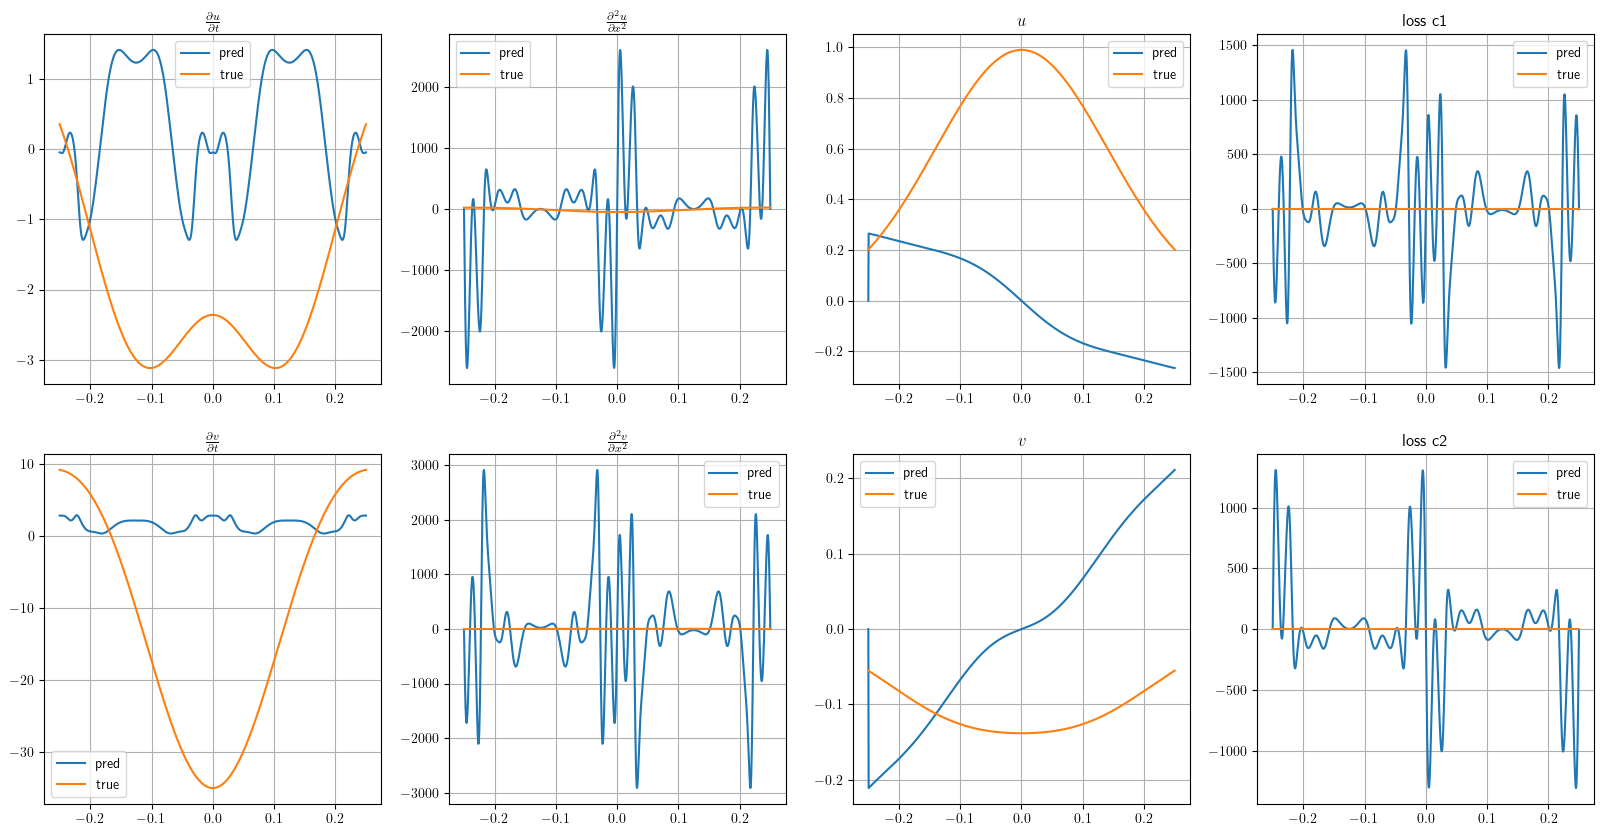

In [3]:
u0_fn = lambda x, t: jnp.exp(-25*x**2)*jnp.cos(-0.2/epsilon*jnp.log(2*jnp.cosh(5*x)))
v0_fn = lambda x, t: jnp.exp(-25*x**2)*jnp.sin(-0.2/epsilon*jnp.log(2*jnp.cosh(5*x)))

u0_fn_ = lambda xt: jnp.exp(-25*xt[0]**2)*jnp.cos(-0.2/epsilon*jnp.log(2*jnp.cosh(5*xt[0])))
v0_fn_ = lambda xt: jnp.exp(-25*xt[0]**2)*jnp.sin(-0.2/epsilon*jnp.log(2*jnp.cosh(5*xt[0])))

du0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 1:2]
dv0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 1:2]

du0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 0:1]
dv0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 0:1]

du0_dxx_fn = lambda xt: jax.vmap(jax.hessian(u0_fn_), in_axes = 0)(xt)[:, 0, 0:1]
dv0_dxx_fn = lambda xt: jax.vmap(jax.hessian(v0_fn_), in_axes = 0)(xt)[:, 0, 0:1]


x = jnp.linspace(*domain[:, 0], 1000).reshape((-1, 1))
t = jnp.zeros_like(x)
xt = jnp.hstack([x, t])


direct_params_ = direct_params

duv_dxt = jacobian(direct_params_, xt)
du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
duv_dxxtt = hessian(direct_params_, xt)
du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
uv = model(direct_params_, xt)
u, v = uv[:, 0:1], uv[:, 1:2]
loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

# du0_dt, dv0_dt = du0_dt_fn(xt), dv0_dt_fn(xt)
du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["text.usetex"] = True

f, ax = plt.subplots(2, 4, figsize = (20, 10))
ax[0][0].plot(x, du_dt, label = "pred")
ax[0][0].plot(x, du0_dt, label = "true")
ax[0][0].set_title(r"$\frac{\partial u}{\partial t}$")
ax[1][0].plot(x, dv_dt, label = "pred")
ax[1][0].plot(x, dv0_dt, label = "true")
ax[1][0].set_title(r"$\frac{\partial v}{\partial t}$")
ax[0][1].plot(x, du_dxx, label = "pred")
ax[0][1].plot(x, du0_dxx, label = "true")
ax[0][1].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
ax[1][1].plot(x, dv_dxx, label = "pred")
ax[1][1].plot(x, dv0_dxx, label = "true")
ax[1][1].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
ax[0][2].plot(x, u, label = "pred")
ax[0][2].plot(x, u0, label = "true")
ax[0][2].set_title(r"$u$")
ax[1][2].plot(x, v, label = "pred")
ax[1][2].plot(x, v0, label = "true")
ax[1][2].set_title(r"$v$")
ax[0][3].plot(x, loss_c1, label = "pred")
ax[0][3].plot(x, loss_c10, label = "true")
ax[0][3].set_title(r"loss c1")
ax[1][3].plot(x, loss_c2, label = "pred")
ax[1][3].plot(x, loss_c20, label = "true")
ax[1][3].set_title(r"loss c2")

for i in range(2):
	for j in range(4):
		ax[i][j].legend()
		ax[i][j].grid()
plt.show()